In [28]:
!pip install requests
!pip install beautifulsoup4
!pip install lxml
!pip install html5lib
!pip install stop_words

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp36-none-any.whl size=32917 sha256=133f368309165c88c5e4c1cdbd9d9f9d93ef074e067ed2790f2014d6436f89b9
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [19]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
soup = BeautifulSoup(open('/content/drive/My Drive/1.html',encoding='utf-8'), 'html.parser')

In [5]:
movie_reviews = soup.find_all('div' , class_ = 'review-container')
print(len(movie_reviews))

1124


In [6]:
sample_movie = movie_reviews[4] # gives us the review
sample_movie.a.text

' Fantasy has never seemed so real\n'

In [9]:
temp = sample_movie.span.text #returns rating 
print(temp)
# we can see that there are \n objects inside the rating







10/10



In [10]:
## Extracting all ratings 
reviews = []
ratings = []

# Extract data from individual movie container
for movie in movie_reviews:
    
    #review
    review = movie.a.text
    reviews.append(review)
    
    #rating
    rating = movie.span.text
    ratings.append(rating)

In [12]:
df = pd.DataFrame({'Review': reviews,'Rating': ratings})
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1124 entries, 0 to 1123
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1124 non-null   object
 1   Rating  1124 non-null   object
dtypes: object(2)
memory usage: 17.7+ KB
None


In [13]:
df.head()

,Review,Rating
0,"Finally, a Show that stays true to it's writt...",\n\n\n\n\n\n9/10\n
1,Excellent adaptation.\n,\n\n\n\n\n\n10/10\n
2,One of the most stunning shows on television\n,\n\n\n\n\n\n10/10\n
3,Lord of the Rings - I think not!\n,\n\n\n\n\n\n10/10\n
4,Fantasy has never seemed so real\n,\n\n\n\n\n\n10/10\n


In [14]:
df.loc[:, 'Rating'] = df['Rating'].str[6:8]
df.loc[:, 'Rating'] = df['Rating'].str.replace('/', '')
df.loc[:, 'Review'] = df['Review'].str.replace('\n', '')
df.loc[:, 'Rating'] = df['Rating'].str.replace('-', '')

In [16]:
def clean(rating):
    return re.sub('[a-zA-Z]+','NaN', rating)

df['Rating'] = df['Rating'].apply(clean)

In [17]:
df = df[df.Rating.str.contains("NaN") == False]
df['Rating'] = df['Rating'].apply(pd.to_numeric)

In [64]:
df.head()

,Review,Rating,Review Length
0,"Finally, a Show that stays true to it's writt...",9.0,54
1,Excellent adaptation.,10.0,22
2,One of the most stunning shows on television,10.0,45
3,Lord of the Rings - I think not!,10.0,33
4,Fantasy has never seemed so real,10.0,33


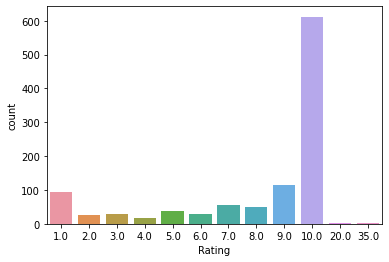

In [21]:
sns.countplot(df['Rating'])

In [22]:
df = df[df.Rating <= 10] ## remove garbage ratings

In [31]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import sent_tokenize, word_tokenize
from collections import Counter
from stop_words import get_stop_words

In [33]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [29]:
a = df['Review'].str.lower().str.cat(sep=' ')
b = re.sub('[^A-Za-z]+', ' ', a)

In [34]:
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords.words('english'))   
stop_words.extend(nltk_words)

newStopWords = ['game','thrones', 'bran', 'stark', 'dragons']
stop_words.extend(newStopWords)

In [36]:
word_tokens = word_tokenize(b)
len(word_tokens)

6030

In [37]:
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

In [38]:
# Remove characters which have length less than 2  
cleaned_data = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in cleaned_data if not word.isnumeric()]  

In [39]:
!pip install textblob

In [41]:
from textblob import TextBlob
#text blob used for sentiment analysis

bloblist_desc = list()

df_review_str=df['Review'].astype(str)

for row in df_review_str:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['Review','sentiment','polarity'])

In [42]:
df_polarity_desc.head()

,Review,sentiment,polarity
0,"Finally, a Show that stays true to it's writt...",0.175,0.825
1,Excellent adaptation.,1.000,1.000
2,One of the most stunning shows on television,0.500,0.750
3,Lord of the Rings - I think not!,0.000,0.000
4,Fantasy has never seemed so real,0.200,0.300


In [43]:
df_polarity_desc.describe()

,sentiment,polarity
count,1065.000000,1065.000000
mean,0.266917,0.464410
std,0.489870,0.356932
min,-1.000000,0.000000
25%,0.000000,0.000000
50%,0.108963,0.454545
75%,0.700000,0.750000
max,1.000000,1.000000


In [45]:
def review_type(df_polarity_desc):
    if df_polarity_desc['sentiment'] >= 0:
        val = "Positive Review"
    elif df_polarity_desc['sentiment'] >= -0.09:
        val = "Neutral Review"
    else:
        val = "Negative Review"
    return val

In [46]:
df_polarity_desc['Sentiment_Type'] = df_polarity_desc.apply(review_type, axis=1)

In [47]:
positive_reviews=df_polarity_desc[df_polarity_desc['Sentiment_Type']=='Positive Review']
negative_reviews=df_polarity_desc[df_polarity_desc['Sentiment_Type']=='Negative Review']

In [48]:
len(positive_reviews), len(negative_reviews) ## to find if there is a bias

(888, 169)

In [57]:
import string

def preprocess(review):
    review_words =[word for word in review if word not in string.punctuation]
    review_words = ''.join(review_words)
    return [word for word in review_words.split() if word.lower() not in stopwords.words('english')]

In [75]:
df=df.dropna(axis=0,how='any')
X_review= df['Review']
y= df['Rating']

In [76]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer=CountVectorizer(analyzer=preprocess).fit(X_review)
X_review = bow_transformer.transform(X_review)

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_review, y, test_size=0.2, random_state=420)

In [78]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB() 

In [79]:
# training the model
nb.fit(X_train, y_train)
predict=nb.predict(X_test)

In [80]:
from sklearn.metrics import classification_report, accuracy_score

print('\n Accuracy:')
print(accuracy_score(y_test, predict))
print(classification_report(y_test, predict))


 Accuracy:
0.5305164319248826
              precision    recall  f1-score   support

         1.0       0.21      0.18      0.19        17
         2.0       0.00      0.00      0.00         5
         3.0       0.00      0.00      0.00         5
         4.0       0.00      0.00      0.00         3
         5.0       0.00      0.00      0.00         7
         6.0       0.00      0.00      0.00         8
         7.0       0.00      0.00      0.00        12
         8.0       0.00      0.00      0.00        15
         9.0       0.18      0.08      0.11        25
        10.0       0.60      0.93      0.73       116

    accuracy                           0.53       213
   macro avg       0.10      0.12      0.10       213
weighted avg       0.36      0.53      0.42       213



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
